This is an implementation of Dice from this paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10179900. Good paper but no source code, so here is some source code. The eventual goal is to build and train an embeddings model. 

First is the pre-processing. The paper does the following pre-processing steps:
- Butterworth band-pass filter with a frequency range of 0.5 to 45 Hz

In [1]:
import mne
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import einops
from scipy.signal import butter, filtfilt


# full_data = torch.tensor([mne.io.read_raw_eeglab(f'ds004504-download/sub-{"{:03}".format(i)}/eeg/sub-{"{:03}".format(i)}_task-eyesclosed_eeg.set', preload=True).get_data() for i in range(1, 89)])

diag = pd.read_csv('ds004504-download/participants.tsv', sep='\t')["Group"]
diags = []
all_data = []
samples_per_epoch = 500 * 30

for i, curr_diag in zip(list(range(1, 89)), diag):
    # apply butterworth to 0.5-45 Hz
    raw = mne.io.read_raw_eeglab(f'ds004504-download/sub-{"{:03}".format(i)}/eeg/sub-{"{:03}".format(i)}_task-eyesclosed_eeg.set', preload=True)    
    raw.filter(0.5, 45, method='iir', iir_params=dict(order=4, ftype='butter'), verbose=False)    
    data = np.asarray(raw.get_data()) # shape: 19, n_samples

    # chop up data into 30_000 sample epochs
    n_samples = data.shape[1]
    n_epochs = n_samples // samples_per_epoch
    data = data[:, :n_epochs*samples_per_epoch].reshape(19, n_epochs, samples_per_epoch)
    all_data.append(data)

    diags.extend([curr_diag]*n_epochs)

all_data = np.concatenate(all_data, axis=1)
all_data = einops.rearrange(all_data, 'channels epochs samples -> epochs channels samples')


In [2]:
# get number of bytes in all_data
print(all_data.nbytes / 1e9, "GB")

5.26224 GB


In [3]:
print(all_data.shape)

(2308, 19, 15000)


In [4]:

import numpy as np
from scipy.signal import butter, filtfilt, welch, csd

def butter_bandpass(lowcut, highcut, fs, order=4):
    """
    Designs a Butterworth bandpass filter.

    Parameters:
    - lowcut: Lower cutoff frequency of the filter.
    - highcut: Upper cutoff frequency of the filter.
    - fs: Sampling frequency.
    - order: Order of the Butterworth filter.

    Returns:
    - b, a: Numerator (b) and denominator (a) polynomials of the filter.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def filter(data, bands, fs, order=4):
    """
    Applies a Butterworth bandpass filter to the data for each specified frequency band.

    Parameters:
    - data: Input signal data (1D array).
    - bands: List of tuples specifying the frequency bands [(low1, high1), (low2, high2), ...].
    - fs: Sampling frequency.
    - order: Order of the Butterworth filter.

    Returns:
    - A 2D array where each row corresponds to the filtered signal for each band.
    """
    ret = []

    for low, high in bands:
        # Design the Butterworth bandpass filter for the given band
        b, a = butter_bandpass(low, high, fs, order=order)
        # Apply the filter to the data
        filtered_signal = filtfilt(b, a, data)
        ret.append(filtered_signal)

    # Stack the filtered signals along the first axis
    return np.stack(ret, axis=0)

rbp = []
scc = []
 
# 0.13 seconds per iter
# since we have 2308 epochs, this will take 2308 * 0.13 = 300
# actual runtime is 276 seconds! this is good
for idx, data in enumerate(all_data):
    # apply bandpass filter
    # Delta: 0.5 – 4 Hz
    # Theta: 4 – 8 Hz
    # Alpha: 8 – 13 Hz
    # Beta: 13-25 Hz
    # Gamma: 25-45 Hz

    bands = [(0.5, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    filtered = filter(data, bands, fs=500) # 5, 19, 15000 (bands, channels, samples)

    # break it into one second epochs (time, bands, channels, sampels), with 30 such epochs
    n_epochs = samples_per_epoch // 500
    filtered = filtered.reshape(5, 19, n_epochs, 500)
    filtered = np.moveaxis(filtered, 2, 0)

    fs = 500
    nperseg = 500
    num_channels = 19

    freqs, psd = welch(filtered, fs=fs, nperseg=nperseg, axis=-1)
    psd_values = np.sum(psd, axis=-1)
    relative_band_power = psd_values / np.sum(psd_values, axis=1, keepdims=True)

    # Compute SCC values
    f_data = np.fft.rfft(filtered, axis=-1)
    auto_spectral = np.mean(np.abs(f_data) ** 2, axis=-1)

    f_data_expanded1 = f_data[:, :, :, np.newaxis, :]
    f_data_expanded2 = f_data[:, :, np.newaxis, :, :]
    cross_spectral = f_data_expanded1 * np.conj(f_data_expanded2)
    mean_cross_psd = np.mean(np.abs(cross_spectral), axis=-1)

    denominator = np.sqrt(auto_spectral[:, :, :, np.newaxis] * auto_spectral[:, :, np.newaxis, :])
    coherence_matrix = mean_cross_psd / denominator

    diag_indices = np.arange(num_channels)
    coherence_matrix[:, :, diag_indices, diag_indices] = 0

    coherence_sum = np.sum(coherence_matrix, axis=-1)
    scc_values = coherence_sum / (num_channels - 1)

    rbp.append(relative_band_power)
    scc.append(scc_values)
    
    if idx % 50 == 0:
        print(idx)

rbp = np.stack(rbp, axis=0)
scc = np.stack(scc, axis=0)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300


In [5]:
pre_reshape_rbp = rbp
pre_reshape_scc = scc

In [21]:
# reshape to (channels, epochs, bands)

print(pre_reshape_rbp.shape)
print(pre_reshape_scc.shape)

rbp = torch.tensor(einops.rearrange(pre_reshape_rbp, 'num epochs bands channels -> num channels epochs bands')).float()
scc = torch.tensor(einops.rearrange(pre_reshape_scc, 'num epochs bands channels -> num channels epochs bands')).float()

print(rbp.shape)
print(scc.shape)

(2308, 30, 5, 19)
(2308, 30, 5, 19)
torch.Size([2308, 19, 30, 5])
torch.Size([2308, 19, 30, 5])


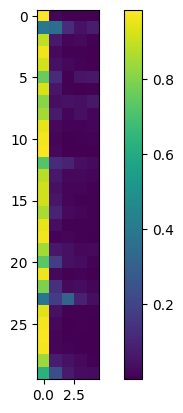

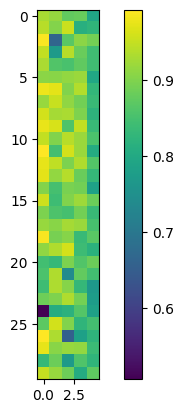

In [18]:
plt.imshow(rbp[500, 3, :, :]) 
plt.colorbar()
plt.show()

plt.imshow(scc[0, 0, :, :])
plt.colorbar()
plt.show()

In [24]:
import torch.nn as nn
from positional_encodings.torch_encodings import PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D, Summer
import jaxtyping



class DiceyModel(nn.Module):
    def __init__(self):
        super(DiceyModel, self).__init__()
        # 30 epochs, 5 bands, 19 channels
        # 2d convolution layer, per epoch

        self.rbp_conv1 = nn.Conv2d(19, 19, (5, 5), stride=1)
        self.scc_conv1 = nn.Conv2d(19, 19, (5, 5), stride=1)

        self.positional_encoding = PositionalEncoding1D(26)
        

    def forward(self, rbp, scc):
        rbp = self.rbp_conv1(rbp).squeeze(-1)
        scc = self.scc_conv1(scc).squeeze(-1)
        print(rbp.shape)

        # gelu each
        rbp = nn.functional.gelu(rbp)
        scc = nn.functional.gelu(scc)

        rbp = self.positional_encoding(rbp)
        scc = self.positional_encoding(scc)

        # apply positional encoding

        pass

In [26]:
model = DiceyModel()
model.forward(rbp[0].unsqueeze(0), scc[0].unsqueeze(0))

torch.Size([1, 19, 26])
